# Align resulting depth map of Marigold with the COLMAP points

In [59]:
# Imports
import os
import numpy as np
import torch
from scipy.interpolate import RegularGridInterpolator
import matplotlib
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# Constants
DATA_DIR = 'scannet/scene0710_00'
MG_TRAIN_DIR = os.path.join(DATA_DIR, 'train/depth_MG')
MG_TRAIN_DIR_OUT = os.path.join(DATA_DIR, 'train/depth_MG_aligned')
MG_TEST_DIR = os.path.join(DATA_DIR, 'test/depth_MG')
COLORED_DEPTH_OUT = os.path.join(DATA_DIR, 'train/depth_MG_aligned_colored')
COLMAP_DIR = os.path.join(DATA_DIR, 'colmap')
COLMAP_TRAIN_DIR = os.path.join(COLMAP_DIR, 'sparse_train/0')
COLMAP_ALL_DIR = os.path.join(COLMAP_DIR, 'sparse/0')
POINT_CLOUDS_TRAIN_OUT = os.path.join(DATA_DIR, 'train/point_clouds_MG_aligned')
BARBARA_POINT_CLOUDS_TRAIN_OUT = os.path.join(DATA_DIR, 'train/barbara_point_clouds')
COLMAP_POINTS_TRAIN_OUT = os.path.join(DATA_DIR, 'train/colmap_point_cloud')
MASK_PATH = os.path.join(DATA_DIR, 'eval_mask.pth')
SENSOR_DEPTH_DIR = os.path.join(DATA_DIR, 'train/target_depth')
SENSOR_DEPTH_SCALED_DIR = os.path.join(DATA_DIR, 'train/depth')
SENSOR_POINT_CLOUD_OUT = os.path.join(DATA_DIR, 'train/sensor_point_cloud')

In [2]:
# Create directories if needed
if not os.path.exists(MG_TRAIN_DIR_OUT):
    os.makedirs(MG_TRAIN_DIR_OUT)
if not os.path.exists(COLORED_DEPTH_OUT):
    os.makedirs(COLORED_DEPTH_OUT)
if not os.path.exists(POINT_CLOUDS_TRAIN_OUT):
    os.makedirs(POINT_CLOUDS_TRAIN_OUT)
if not os.path.exists(BARBARA_POINT_CLOUDS_TRAIN_OUT):
    os.makedirs(BARBARA_POINT_CLOUDS_TRAIN_OUT)
if not os.path.exists(COLMAP_POINTS_TRAIN_OUT):
    os.makedirs(COLMAP_POINTS_TRAIN_OUT)
if not os.path.exists(SENSOR_POINT_CLOUD_OUT):
    os.makedirs(SENSOR_POINT_CLOUD_OUT)

In [3]:
def get_colmap_camera_matrix(colmap_cameras_path):
    with open(colmap_cameras_path, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if not line.startswith('#')]    # Skip all lines that begin with # (comments)
        # Extract image size
        # 1 SIMPLE_PINHOLE 624 468 600.941 312 234
        image_size = tuple(map(int, lines[0].split(' ')[2:4]))
        # Extract the camera parameters
        camera_params = lines[0].split(' ')[-3:]
        # Extract the focal length and principal point
        f, cx, cy = map(float, camera_params)
        # Construct the camera matrix
        K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])
    return image_size, K

def get_colmap_dict_points(colmap_points_path):
    colmap_points_dict = {}
    with open(colmap_points_path, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if not line.startswith('#')]    # Skip all lines that begin with # (comments)
        for line in lines:
            line = line.strip().split()
            # 3D point list with one line of data per point:
            # POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
            point_id = int(line[0])
            x = float(line[1])
            y = float(line[2])
            z = float(line[3])
            r = int(line[4])
            g = int(line[5])
            b = int(line[6])
            error = float(line[7])
            track = line[8:]
            for i in range(8, len(line), 2):
                image_id = int(line[i])
                point2d_idx = int(line[i + 1])
                track.append((image_id, point2d_idx))
            colmap_points_dict[point_id] = (x, y, z, r, g, b, error, track)
    return colmap_points_dict

def get_colmap_points(colmap_images_path, image_id):
    # Read the images.txt file which has the following format:
    #   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
    #   POINTS2D[] as (X, Y, POINT3D_ID)
    with open(colmap_images_path) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if not line.startswith('#')]    # Skip all lines that begin with # (comments)
        # Find the line corresponding to the image_id
        points_2d = []
        points_3d_ids = []
        q = None
        t = None
        for idx, line in enumerate(lines):
            if str(line).endswith(str(image_id) + '.jpg'):
                # Read the camera transformation
                q = list(map(float, lines[idx].split(' ')[1:5]))
                t = list(map(float, lines[idx].split(' ')[5:8]))
                # lines[idx+1] contains the POINTS2D[] line
                line_points = lines[idx+1].split(' ')
                # Read three elements at a time
                for i in range(0, len(line_points), 3):
                    x, y, point_3d_id = line_points[i:i+3]
                    if point_3d_id != '-1':
                        points_2d.append((float(x), float(y)))
                        points_3d_ids.append(int(point_3d_id))

    return q, t, points_2d, points_3d_ids

In [4]:
import numpy as np

def quaternion_to_rotation_matrix(q):
    """
    Convert a quaternion into a 3x3 rotation matrix.
    """
    qw, qx, qy, qz = q
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])
    return R

def rotation_traslation_to_matrix(R, t):
    """
    Convert a rotation matrix and a translation vector into a 4x4 transformation matrix.
    """
    Tr = np.eye(4)
    Tr[:3, :3] = R
    Tr[:3, 3] = t
    return Tr

def transform_points(points_3d, Tr):
    """
    Transform 3D points from world coordinates to camera coordinates.
    
    Parameters:
    points_3d : ndarray of shape (n, 3)
        The 3D points in world coordinates.
    T : ndarray of shape (4, 4)
        The transformation matrix from world to camera coordinates.
    Returns:
    points_3d_transformed : ndarray of shape (n, 3)
        The transformed 3D points in camera coordinates.
    """
    # Add a column of ones to the points_3d
    points_3d_homogeneous = np.hstack([points_3d, np.ones((points_3d.shape[0], 1))])
    # Transform the points
    points_3d_transformed = (Tr @ points_3d_homogeneous.T).T[:, :3]
    return points_3d_transformed

def compute_depth(points_3d_transformed):
    """
    Compute the depth values from the transformed 3D points.
    
    Parameters:
    points_3d_transformed : ndarray of shape (n, 3)
        The transformed 3D points in camera coordinates.
    
    Returns:
    depths : ndarray of shape (n,)
        The depth values (z-coordinates) of the transformed points.
    """
    return points_3d_transformed[:, 2]

In [5]:
def project_points(K, points_3d):
    """
    Project 3D points onto the image plane using the intrinsic matrix K.
    
    Parameters:
    K : ndarray of shape (3, 3)
        The intrinsic matrix.
    points_3d : ndarray of shape (n, 3)
        The 3D points in camera coordinates.
    
    Returns:
    points_2d : ndarray of shape (n, 2)
        The projected 2D points on the image plane.
    depths : ndarray of shape (n,)
        The depth values (z-coordinates) of the transformed points.
    """
    # Convert 3D points to homogeneous coordinates
    # points_3d_h = np.hstack([points_3d, np.ones((points_3d.shape[0], 1))])
    
    # Project to 2D (homogeneous coordinates)
    points_2d_h = (K @ points_3d.T).T
    
    # Convert to non-homogeneous coordinates
    points_2d = points_2d_h[:, :2] / points_2d_h[:, 2:]
    depths = points_3d[:, 2]  # Extract depth values (z-coordinates)
    
    return points_2d, depths

def filter_points_in_image(points_2d, depths, image_width, image_height):
    """
    Filter points to determine which ones lie within the camera plane.
    
    Parameters:
    points_2d : ndarray of shape (n, 2)
        The projected 2D points on the image plane.
    depths : ndarray of shape (n,)
        The depth values of the points.
    image_width : int
        The width of the image.
    image_height : int
        The height of the image.
    
    Returns:
    mask : ndarray of shape (n,)
        A boolean array indicating which points are within the image boundaries and in front of the camera.
    """
    mask = (
        (points_2d[:, 0] >= 0) & (points_2d[:, 0] < image_width) &  # x coordinates within image width
        (points_2d[:, 1] >= 0) & (points_2d[:, 1] < image_height) &  # y coordinates within image height
        (depths > 0)  # points in front of the camera
    )
    return mask


In [6]:
def interpolate_depth(depth_map, points_2d):
    # Define the grid coordinates
    y = np.arange(depth_map.shape[0])
    x = np.arange(depth_map.shape[1])

    # Create the interpolator object
    interpolator = RegularGridInterpolator((y, x), depth_map)

    # Interpolate the depth values at the 2D points
    interpolated_depths = interpolator(points_2d)

    return interpolated_depths

def align_depth_map_with_3d_points(depth_map, points_2d, ground_truth_depths, points_error):
    # Interpolate the depth values at the 2D points
    depths = interpolate_depth(depth_map, points_2d)
    # print(f'MG_PREDICTION: {depths}')
    # print(f'COLMAP_GT: {ground_truth_depths}')
    
    print(f'Error before: {np.sqrt(np.mean((depths - ground_truth_depths)**2))}')

    # Reject outliers
    # inds1 = np.argsort(depths)
    # inds2 = np.argsort(ground_truth_depths)

    # mask = (np.abs(inds1 - inds2) < (depths.shape[0] // 4))  & (depths >= 0.1) & (depths <= 0.9)
    # ground_truth_depths = ground_truth_depths[mask]
    # points_error = points_error[mask]
    # depths = depths[mask]

    # Calculate the square root of the weights (use inverse error as weights and consider the relative error per point)
    #sqrt_weights = np.sqrt(1.0 / ((points_error ** 2))) # Note using the squared error (error ** 4 here) gives worse results
    if points_error == None:
        sqrt_weights = np.sqrt(1.0 / (ground_truth_depths ** 2))
    else:
        sqrt_weights = np.sqrt(1.0 / ((ground_truth_depths ** 2) * (points_error ** 4)))
    
    # Set up the weighted linear system: sqrt(W) * (A @ [a, b]) = sqrt(W) * depth_ground_truth_valid
    A = torch.tensor(np.vstack([depths, np.ones_like(depths)]).T, dtype=torch.float32)
    b = torch.tensor(ground_truth_depths, dtype=torch.float32)
    W = torch.tensor(np.diag(sqrt_weights), dtype=torch.float32)

    # Solve for the scale (a) and shift (b) parameters using the weighted system
    params = torch.linalg.inv(A.T @ W @ A) @ A.T @ W @ b
    
    # Extract scale and shift
    s, t = params
    s = s.numpy()
    t = t.numpy()

    # Compute the error
    error = np.sqrt(np.mean((s * depths + t - ground_truth_depths)**2))
    print(f'Error after: {error}')
    print(f'Scale : {s}, Shift: {t}')
    
    return s, t, error

In [7]:
def colorize_depth_maps(depth_map, min_depth, max_depth, cmap="Spectral"):
    """
    Colorize depth maps.
    """
    assert len(depth_map.shape) >= 2, "Invalid dimension"

    depth = depth_map.copy().squeeze()
    # reshape to [ (B,) H, W ]
    if depth.ndim < 3:
        depth = depth[np.newaxis, :, :]

    # colorize
    cm = matplotlib.colormaps[cmap]
    depth = ((depth - min_depth) / (max_depth - min_depth)).clip(0, 1)
    img_colored_np = cm(depth, bytes=False)[:, :, :, 0:3]  # value from 0 to 1
    img_colored_np = np.rollaxis(img_colored_np, 3, 1)

    return img_colored_np

def chw2hwc(chw):
    assert 3 == len(chw.shape)
    if isinstance(chw, np.ndarray):
        hwc = np.moveaxis(chw, 0, -1)
    return hwc

def get_colorized_depth_map(depth_pred, color_map="Spectral", valid_mask=None):
    min_depth = 0
    max_depth = 20
    depth_colored = colorize_depth_maps(depth_pred, min_depth, max_depth, cmap=color_map).squeeze()  # [3, H, W], value in (0, 1)
    depth_colored = (depth_colored * 255).astype(np.uint8)
    depth_colored_hwc = chw2hwc(depth_colored)
    depth_colored_img = Image.fromarray(depth_colored_hwc)
    return depth_colored_img

In [51]:
# Save point cloud to obj file
def save_point_cloud_to_obj(points, filename, colors=None):
    with open(filename  + '.obj', 'w') as f:
        for i in range(points.shape[0]):
            # Write the vertices with colors
            point = points[i, :]
            if colors is not None:
                color = colors[i, :]
                f.write('v %f %f %f %f %f %f\n' % (point[0], point[1], point[2], color[0], color[1], color[2]))
            else:
                f.write('v %f %f %f\n' % (point[0], point[1], point[2]))

def save_point_cloud(metric_depth_pred, image, K, camera_to_world, out_path, mask=None):
    # Prepare colors array
    colors = image.reshape(-1, 3)

    # Create grid for the image plane
    FINAL_WIDTH, FINAL_HEIGHT = image.shape[1], image.shape[0]
    x, y = np.meshgrid(np.arange(FINAL_WIDTH), np.arange(FINAL_HEIGHT))

    # Normalize coordinates using the intrinsic matrix parameters
    focal_length_x = K[0, 0]
    focal_length_y = K[1, 1]
    c_x = K[0, 2]
    c_y = K[1, 2]
    x_normalized = (x - c_x) / focal_length_x
    y_normalized = (FINAL_HEIGHT - y - c_y) / focal_length_y

    # Depth values from resized_pred
    z = np.array(metric_depth_pred)
    # Calculate 3D points by unprojecting
    points = np.stack((np.multiply(x_normalized, z), np.multiply(y_normalized, z), -z), axis=-1).reshape(-1, 3)
    # Convert points to homogeneous coordinates
    points = np.hstack((points, np.ones((points.shape[0], 1))))
    # Convert points from camera coordinates to world coordinates
    points = camera_to_world.dot(points.T).T
    # Get (x, y, z) coordinates
    points = points[:, :3]
    if mask is not None:
        save_point_cloud_to_obj(points[mask], out_path, colors[mask])
    else:
        save_point_cloud_to_obj(points, out_path, colors)

    return points

In [52]:
def convert_depth_completion_scaling_to_m(depth):
    # convert from depth completion scaling to meter, that means map range 0 .. 1 to range 0 .. 16,38m
    return depth * (2 ** 16 - 1) / 4000.

def compute_rmse(prediction, target):
    return torch.sqrt((prediction - target).pow(2).mean())


In [53]:
# Load JSON file
import json
def load_json(filename):
    with open(filename, 'r') as f:
        return json.load(f)
meta = load_json('scannet/scene0710_00/transforms_train.json')

In [99]:
meta['frames'][0]['depth_file_path']

'train/depth/458.png'

In [104]:
meta['frames'][0]['fx']

579.97802734375

In [1]:
barbara_depths = torch.load(os.path.join(DATA_DIR, 'depths.pth'))
# Get camera matrix
image_size, K = get_colmap_camera_matrix(os.path.join(COLMAP_TRAIN_DIR, 'cameras.txt'))
image_width, image_height = image_size
# Get dictionary of points
points_dict = get_colmap_dict_points(os.path.join(COLMAP_TRAIN_DIR, 'points3D.txt'))
errors = []
rmse_erros = []
aligned_depths = []
sensor_depths = []
K[0, 0] = meta['frames'][0]['fx']
K[1, 1] = meta['frames'][0]['fy']
K[0, 2] = meta['frames'][0]['cx']
K[1, 2] = meta['frames'][0]['cy']
valid_indexes = []

# Iterate over the depths in the directory
for i, meta_i in enumerate(meta['frames']): #os.listdir(MG_TRAIN_DIR)):
    filename = meta_i['file_path']
    filename = os.path.basename(filename).split('.')[0] + '.npy'
    if not filename.endswith('uncertainty.npy'):
        image_id = filename.split('.')[0]
        print(f'IMAGE {image_id}:')
        # Get relative depth from Marigold
        relative_depth = np.load(os.path.join(MG_TRAIN_DIR, filename))
        image = np.array(Image.open(os.path.join(DATA_DIR, 'train/rgb', image_id + '.jpg'))) / 255.0
        # Invert the transformation matrix to get the camera-to-world matrix
        camera_to_world = np.array(meta_i['transform_matrix'])
                # Visualzie Barbara's images
        barbara_depth = barbara_depths[i, :, :].numpy()
        save_point_cloud(barbara_depth, image, K, camera_to_world, os.path.join(BARBARA_POINT_CLOUDS_TRAIN_OUT, image_id))
        # Get points from COLMAP for the same image
        # LEGACY CODE FOR USING COLMAP POINTS
        # colmap_images_path = os.path.join(COLMAP_TRAIN_DIR, 'images.txt')
        # q, t, _, points_3d_ids = get_colmap_points(colmap_images_path, image_id)
        # points_3d = [points_dict[point_id] for point_id in points_3d_ids]
        # # Select the first three elements of the points_3d
        # points_3d_xyz = np.array([point[:3] for point in points_3d])
        # points_error = np.array([point[6] for point in points_3d])
        # # Transform the 3D points into camera coordinates
        # Tr = rotation_traslation_to_matrix(quaternion_to_rotation_matrix(q), t)
        # print(Tr)
        # if points_3d_xyz.shape[0] == 0:
        #     print(f'NO POINTS FOR IMAGE {image_id}')
        #     continue
        # points_3d_transformed = transform_points(np.array(points_3d_xyz)[:, :3], Tr)
        # # Sanity check. Project points and get depths
        # points_2d, depths = project_points(K, points_3d_transformed)
        # # Sanity check. Filter points within the image boundaries
        # mask = filter_points_in_image(points_2d, depths, image_width, image_height)
        # if mask.any() == False:
        #     # This should never happen if the points from COLMAP are correct
        #     print(f'WARNING, ALL COLMAP POINTS SHOULD LIE INSIDE THE IMAGE PLANE {image_id}')
        #     continue
        # Recover metric depth from the colmap points
        dense_depth_priors_depth = np.array(Image.open(os.path.join(DATA_DIR, meta_i['depth_file_path'])), dtype=np.float64) / 1000.0
        # dense_depth_priors_depth_mask = dense_depth_priors_depth.flatten() > 0
        # Get indexes for the pixels with actual depth
        points_2d = np.where(dense_depth_priors_depth > 0)
        if points_2d[0].shape[0] == 0:
            print(f'NO POINTS FOR IMAGE {image_id}')
            continue
        valid_indexes.append(i)
        # Get the depth values using indexes
        depths = dense_depth_priors_depth[points_2d]
        print('Max barbaras depth:', dense_depth_priors_depth.max())
        # Align the depth map with the 3D points
        s, t, error = align_depth_map_with_3d_points(relative_depth, points_2d, depths, None)
        errors.append(error)
        # Modify the depth map using the found scale and shift
        aligned_depth = s * relative_depth + t
        print(f'MAX DEPTH: {aligned_depth.max()}, MAX DEPTH GT: {depths.max()}')
        print(f'MIN DEPTH: {aligned_depth.min()}, MIN DEPTH GT: {depths.min()}')
        if aligned_depth.min() < 0:
            print(f'NEGATIVE DEPTH HERE: {filename}, ID: {i}')
        print()
        # Save the aligned depth map
        np.save(os.path.join(MG_TRAIN_DIR_OUT, filename), aligned_depth)
        # Scale the uncertainty values
        # uncertainty_filename = filename.replace('.npy', '_uncertainty.npy')
        # uncertainty = np.load(os.path.join(MG_TRAIN_DIR, uncertainty_filename))
        # np.save(os.path.join(MG_TRAIN_DIR_OUT, uncertainty_filename), uncertainty * s)
        # Plot the depth map
        colored_save_path = os.path.join(COLORED_DEPTH_OUT, filename.replace('.npy', '.png'))
        if os.path.exists(colored_save_path):
            print(f"Existing file: '{colored_save_path}' will be overwritten")
        depth_colored = get_colorized_depth_map(aligned_depth)
        depth_colored.save(colored_save_path)
        # Unproject and save point cloud
        # print(camera_to_world)
        # camera_to_world = np.linalg.inv(Tr)
        save_point_cloud(aligned_depth, image, K, camera_to_world, os.path.join(POINT_CLOUDS_TRAIN_OUT, image_id))
        print('Max aligned:', aligned_depth.max())
        aligned_depths.append(aligned_depth)
        # Visualize COLMAP points
        # colors = np.zeros_like(points_3d_xyz)
        # colors[:, 0] = 1.0
        # save_point_cloud_to_obj(points_3d_xyz, os.path.join(COLMAP_POINTS_TRAIN_OUT, image_id), colors)
        # Load sensor depth and save it as a pointcloud
        sensor_depth = np.array(Image.open(os.path.join(SENSOR_DEPTH_DIR, filename.replace('.npy', '.png'))), dtype=np.float64) / 1000.0
        sensor_depth_mask = sensor_depth.flatten() > 0
        print('Max sensor:', sensor_depth.max())
        save_point_cloud(sensor_depth, image, K, camera_to_world, os.path.join(SENSOR_POINT_CLOUD_OUT, image_id), sensor_depth_mask)
        print()
        print()

NameError: name 'torch' is not defined

In [62]:
def load_ground_truth_depth(basedir, train_filenames, image_size, depth_scaling_factor):
    H, W = image_size
    gt_depths = []
    gt_valid_depths = []
    for filename in train_filenames:
        filename = filename.replace("rgb", "target_depth")
        filename = filename.replace(".jpg", ".png")
        gt_depth_fname = os.path.join(basedir, filename)
        if os.path.exists(gt_depth_fname):
            gt_depth = np.array(Image.open(gt_depth_fname), dtype=np.float64)
            gt_valid_depth = gt_depth > 0.5
            gt_depth = (gt_depth / depth_scaling_factor).astype(np.float32)
        else:
            gt_depth = np.zeros((H, W))
            gt_valid_depth = np.full_like(gt_depth, False)
        gt_depths.append(np.expand_dims(gt_depth, -1))
        gt_valid_depths.append(gt_valid_depth)
    gt_depths = np.stack(gt_depths, 0)
    gt_valid_depths = np.stack(gt_valid_depths, 0)
    return gt_depths, gt_valid_depths

In [97]:
valid_imgs = torch.tensor(valid_indexes)
eval_mask = torch.load(MASK_PATH)[valid_imgs, :, :]
sensor_depth, _ = load_ground_truth_depth(DATA_DIR, [frame['file_path'] for frame in meta['frames']], (468, 624), 1000)
sensor_depth = torch.tensor(sensor_depth, dtype=torch.float32)[valid_imgs, :, :]

In [ ]:
# n = 4688436
# fig, axes = plt.subplots(1, 2)
# axes[0].hist(torch.sort((x - y).square())[0][int(0.9 * n):], bins=100)
# axes[1].hist(torch.sort((z - y).square())[0][int(0.9 * n):], bins=100)

In [ ]:
# depths = torch.tensor(aligned_depths).clamp(min=near, max=far)
# x, y = depths[:, :, :][eval_mask], gt_depths_train.squeeze(-1)[eval_mask]
# z = torch.tensor(barbara_depths).clamp(min=near, max=far)[eval_mask]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 18 but corresponding boolean dimension is 17

In [98]:
# Our errors
near = 0.10000000149011612
far = 6.8439249992370605
depths = torch.tensor(aligned_depths)
# depths = torch.tensor(aligned_depths).clamp(min=near, max=far)
gt_depths_train = sensor_depth #torch.tensor(sensor_depths, dtype=torch.float32) / 1000.0

print('rmse: ', compute_rmse(depths[eval_mask], gt_depths_train.squeeze(-1)[eval_mask]))
print('l1: ', torch.abs(depths[eval_mask] - gt_depths_train.squeeze(-1)[eval_mask]).mean())

rmse tensor(0.1504)
l1 tensor(0.1115)


In [102]:
# Original Dense Depth Priors errors
near = 0.10000000149011612
far = 6.8439249992370605
b_depths = torch.tensor(barbara_depths[valid_imgs, :, :]).clamp(min=near, max=far)
gt_depths_train = sensor_depth #torch.tensor(sensor_depths, dtype=torch.float32) / 1000.0

print('rmse', compute_rmse(b_depths[eval_mask], gt_depths_train.squeeze(-1)[eval_mask]))
print('l1', torch.abs(b_depths[eval_mask] - gt_depths_train.squeeze(-1)[eval_mask]).mean())

/var/folders/mz/h5vgbzmx1zn2p9ykvcgn5nmr0000gn/T/ipykernel_8903/276558073.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_depths = torch.tensor(barbara_depths[valid_imgs, :, :]).clamp(min=near, max=far)


rmse tensor(0.1667)
l1 tensor(0.1179)


In [ ]:
MG = np.array("""0.92311835 0.81285122 0.99780128 0.9978027  0.99910212 0.87367186
 0.96037075 0.74939478 0.87712003 0.87739623 0.83519974 0.9448635
 0.80720212 0.86259123 0.26592    0.98991484 0.47514004 0.39912075
 0.39864154 0.39772929 0.39007082 0.38543097 0.36674451 0.36643473
 0.34636011 0.37731688 0.39430885 0.36558432 0.2851687  0.25192033
 0.37966008 0.38781502 0.36932784 0.3493744  0.34800433 0.30751557
 0.39822312 0.28136278 0.12603639 0.19965066 0.38719475 0.35178993
 0.40262796 0.34315901 0.98710698 0.99068907 0.2586416  0.86555818
 0.99139911 0.906987   0.3562793  0.34058693 0.23529631 0.36752775
 0.35654674 0.32756804 0.10934264 0.18310302 0.08814433 0.04501238
 0.39809091 0.40091498 0.3912468  0.3969043  0.99700975 0.2486549
 0.3756891  0.38855474 0.23131975 0.38869273 0.25983182 0.39430761
 0.16821594 0.34961077 0.12170791 0.10871744 0.38870337 0.40683461
 0.99673735 0.40177445 0.40270529 0.40733053 0.99787388 0.40283564
 0.26476119 0.7970672  0.40595117 0.26782383 0.26782383 0.40596425
 0.40924552 0.23128703 0.25812098 0.3851798  0.40050768 0.38138267
 0.23504946 0.24178501 0.27975736 0.36492036 0.25814735 0.25321548
 0.48416192 0.25696702 0.27905127 0.2316759  0.27798549 0.3546036
 0.25338018 0.26230389 0.32692986 0.25362472 0.2976681  0.33210846
 0.33210846 0.38822455 0.27088835 0.32605998 0.32605998 0.27079546
 0.40308195 0.23660462 0.17847553 0.39565669 0.39713571 0.24544372
 0.23528303 0.24122228 0.58697269 0.2492377  0.43478799 0.26276355
 0.40058031 0.99593037 0.42225914 0.25343987 0.25287061 0.24638936
 0.39496864 0.40337567 0.27827563 0.24953201 0.26746817 0.26746817
 0.24084616 0.26775994 0.37034575 0.24161727 0.23696146 0.91976447
 0.23955094 0.5282835  0.23614506 0.26833786 0.38784051 0.25283926
 0.4191585  0.4191585  0.4062488  0.4062488  0.20820358 0.19180747
 0.21805815 0.27530785 0.98727732 0.34527542 0.28711521 0.24544732
 0.34588176 0.27601448 0.22731332 0.11980327 0.43900011 0.43900011
 0.37437561 0.3600695  0.17678432 0.9980461  0.38584605 0.38584605
 0.59434362 0.32362897 0.24801194 0.31884564 0.17351372 0.34621392
 0.16581241 0.3995579  0.55681871 0.24263683 0.28981538 0.27579858
 0.25650011 0.99697126 0.4292884  0.35175747 0.81941948 0.99618095
 0.289021   0.27031374 0.27562378 0.19607506 0.14861517""".split()).astype(np.float32)
COLMAP_GT = np.array("""12.89299293  9.99894561 16.39534264 16.53394655 16.27007179 13.50098929
 14.33597913  8.9918477  12.15170648 11.88680214 11.7846614  13.79346493
 11.41813503 11.98766747  4.41729762 11.42639676  9.04505326  7.1022251
  6.76414634  6.80483276  6.21346587  6.41254842  5.38281322  6.31147781
  6.3090856   5.98031445  1.60572111  6.44129408  5.12222978  4.57577858
  5.95104475  4.55149534  5.88392971  6.35447925  6.02659455  7.16620559
  7.21190153  8.38511982  3.03197212  3.71548237  7.16335855  6.32429107
  7.01780523  6.27943446 13.72818637 13.74192357  4.61639412  9.92272557
 14.3548502  12.36357797  6.23868807  6.16879137  3.93606492  6.8711296
  6.12174508  6.31031394  4.03895164  4.23463491  3.62484877  3.40655827
  6.35933429  6.49932814  6.70545586  6.55801165 12.64523848  4.57538944
  6.46327914  6.14740424  4.46665784  7.17224327  4.62873328  7.39849703
  3.98514879  5.31426617  3.08870187  3.44386604  6.73218632  6.48405699
 13.49541332  6.48719636  6.37734377  6.41358156 13.66654849  6.5972455
  4.82526601 11.34004798  6.5945944   4.90046084  4.90046084  6.68981065
  6.97144582  4.50212074  4.23265102  7.27739126  6.73644953  7.13908442
  4.40502492  4.39443064  5.16114377  6.18777321  4.22063088  4.54095223
 10.412013    4.58772277  5.20992641  4.77238572  5.18496223  6.6981369
  4.9706411   5.19486074  5.69119221  6.09416048  4.72815524  6.34573153
  6.34573153  7.28649688  4.869599    6.3094488   6.3094488   5.14870944
  6.30706035  4.83162911  3.21514237  6.63942717  6.71533506  4.32005784
  4.3484181   4.67261223 10.29867942  4.41722275  6.7423253   4.61817414
  6.86598846 10.64102709  7.36924985  4.83942364  4.24895932  4.35119568
  6.80909844  6.80629635  5.0617495   4.37134183  5.20018137  5.20018137
  4.38874743  5.13773545  6.51423739  4.53886312  4.54740558 13.07734471
  4.60573592  9.22480929  4.70012781  4.5995448   5.96959078  4.7806371
  6.34426428  6.34426428  6.28244301  6.28244301  4.36918536  4.19159989
  4.32106673  4.84005129 13.30137922  6.34365598  5.04173093  4.59743051
  5.78384008  4.84138985  4.54707525  3.43884464  7.25909561  7.25909561
  6.46697147  6.60679343  4.03031974 15.50287864  7.0488598   7.0488598
  9.08359784  6.78316873  4.93176668  5.49041996  3.93854506  5.50916256
  3.57162832  7.54554078  9.93792718  4.77257145  5.6979839   4.52667124
  4.85322099 14.05682165  6.98070009  5.89276949 11.84911944 11.4253811
  4.85138051  4.93331788  5.10382569  4.79031181  3.42358299""".split()).astype(np.float32)

In [ ]:
MG.shape

(203,)

In [ ]:
MG.shape[0], mask.sum()

(203, 266)

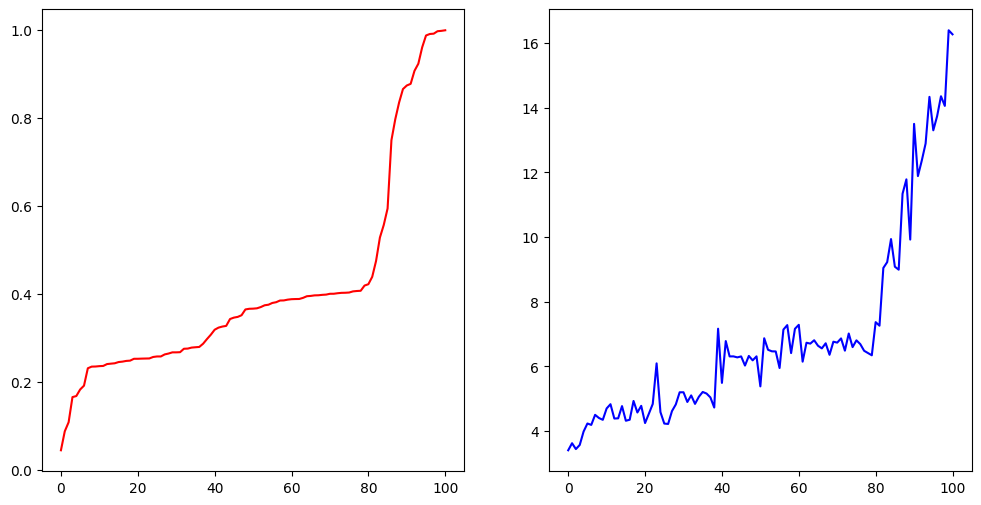

In [ ]:


inds1 = np.argsort(MG)
inds2 = np.argsort(COLMAP_GT)

mask = (np.abs(inds1 - inds2) < (MG.shape[0] // 4)) 

# Plot histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(range(MG[inds1][mask].shape[0]), MG[inds1][mask], c='red')
axes[1].plot(range(MG[inds1][mask].shape[0]), COLMAP_GT[inds1][mask], c='blue')


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  4.,
         2.,  1.,  3.,  2.,  5., 11., 11.,  9., 12.,  5.,  8.,  5.,  1.,
         2.,  3.,  2.,  4.,  6., 19.,  9.,  5., 12.,  3.,  5.,  8.,  3.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  1.,
         0.,  0.,  0.,  2.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
         4.,  0.,  0.,  3.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,
         1.,  2.,  1.,  3.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  2.]),
 array([ 1.60572112,  1.75500333,  1.90428567,  2.05356789,  2.2028501 ,
         2.35213232,  2.50141478,  2.65069699,  2.79997921,  2.94926143,
         3.09854364,  3.24782586,  3.39710832,  3.54639053,  3.69567275,
         3.84495497,  3.99423718,  4.1435194 ,  4.29280186,  4.44208384,
         4.59136629,  4.74064875,  4.88993073,  5.03921318,  5.18849516,
         5.33777761,  5.48706007,  5.63634205,  5.7856245 ,  5.934906

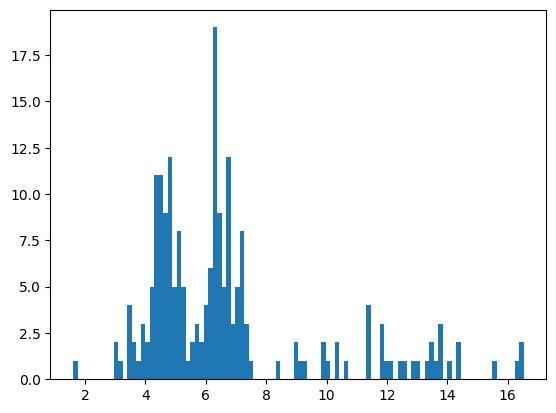

In [ ]:
plt.hist(COLMAP_GT, bins=100)